In [1]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D, Reshape,Input
import tensorflow.keras.backend as K
from tensorflow.keras.layers import concatenate

In [2]:
dinfo = pd.read_csv("data/info.csv")
dinfo.head(10)

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train
5,0,train/ADONIS/006.jpg,ADONIS,train
6,0,train/ADONIS/007.jpg,ADONIS,train
7,0,train/ADONIS/008.jpg,ADONIS,train
8,0,train/ADONIS/009.jpg,ADONIS,train
9,0,train/ADONIS/010.jpg,ADONIS,train


In [3]:
dinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13594 entries, 0 to 13593
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   13594 non-null  int64 
 1   filepaths  13594 non-null  object
 2   labels     13594 non-null  object
 3   data set   13594 non-null  object
dtypes: int64(1), object(3)
memory usage: 424.9+ KB


<Axes: xlabel='labels'>

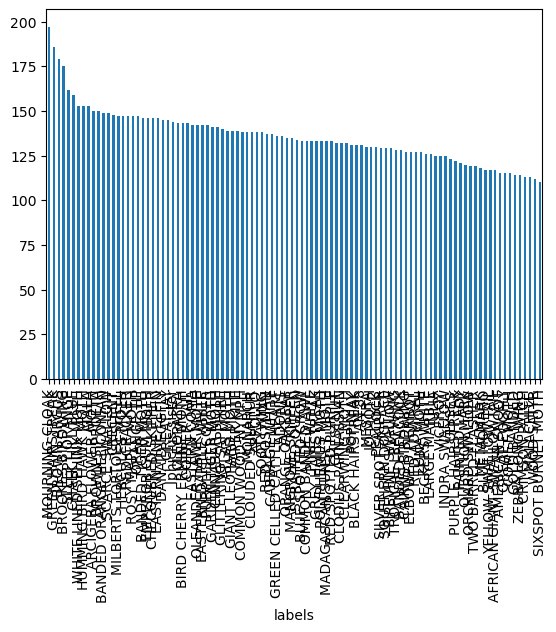

In [4]:
dinfo.labels.value_counts().plot.bar()

In [5]:
df = dinfo[dinfo["data set"] == "train"]


In [6]:
%%time

def lab_ab_in_rgb(lab: np.array, ab: np.array):
    """
    :param lab: grey
    :param ab: many
    :return: np.array shape = 1,224,224,3
    """

    image = np.zeros(shape=(224, 224, 3))
    image[:, :, 0] = np.clip(lab[0][:, :, 0], 0, 100)
    image[:, :, 1:] = np.clip(ab, -128, 127) * 128

    return np.array(lab2rgb(image))


def conver_good_size(img):
    if type(img) != Image:
        img = Image.fromarray(np.squeeze(img))

    img = img.resize((224, 224))
    image = np.array(img, dtype=float)
    return image


def processed_image(img):
    image = conver_good_size(img)
    size = image.shape
    lab = rgb2lab(1.0 / 255 * image)
    X, ab = lab[:, :, 0], lab[:, :, 1:]

    ab /= 128
    X = X.reshape(1, size[0], size[1], 1)
    ab = ab.reshape(1, size[0], size[1], 2)
    return X, ab, np.array(image, dtype=int)


class DataSet:

    def __init__(self, path="data", stat="train"):
        self.path = path
        dinfo = pd.read_csv(f"{path}/info.csv")
        self.dinfo = dinfo[dinfo["data set"] == stat]

    def get_data(self, process=False):
        size = len(self.dinfo.filepaths)
        if process is False:
            x_data = np.zeros((size, 224, 224, 3), dtype=np.uint8)
            y2_data = None
            input_imag = None
        else:
            input_imag = np.zeros((size, 224, 224, 3), dtype=np.uint8)
            x_data = np.zeros((size, 224, 224, 1), dtype=np.uint8)
            y2_data = np.zeros((size, 224, 224, 2), dtype=np.uint8)
        y_data = np.zeros((size,), dtype=np.uint8)
        n = 0
        for id_cl, fl, *_ in self.dinfo.values:
            ph = Image.open(f"{self.path}/{fl}")
            if process is False:
                x_data[n] = np.array(ph, dtype=np.uint8)
            else:
                x_data[n], y2_data[n], input_imag[n] = processed_image(ph)

            y_data[n] = id_cl

            n += 1

        return x_data, y_data, y2_data, input_imag


x_train, y_train, y2_train, train_input = DataSet().get_data(True)
x_test, y_test,y2_test, test_input = DataSet(stat="test").get_data(True)
x_val, y_val,y2_val, val_input = DataSet(stat="valid").get_data(True)

CPU times: user 59.2 s, sys: 7.8 s, total: 1min 7s
Wall time: 1min 8s


(12594, 224, 224, 1) (12594,) (12594, 224, 224, 2)


Text(0.5, 1.0, 'image X')

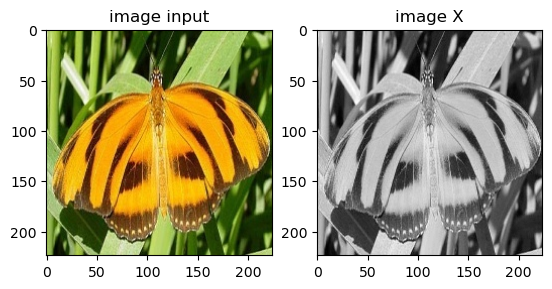

In [7]:
print(x_train.shape, y_train.shape, y2_train.shape)
n = 1000
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.squeeze(train_input[n]))
ax[0].set_title("image input")

ax[1].imshow(np.squeeze(x_train[n]), cmap="gray")
ax[1].set_title("image X")